# Ready, Steady, Go AI (*Tutorial*)

This tutorial is a supplement to the paper, **Ready, Steady, Go AI: A Practical Tutorial on Explainable Artificial Intelligence and Its Applications in Plant Digital Phenomics** (submitted to *Patterns, 2021*) by Farid Nakhle and Antoine Harfouche

Read the accompanying paper [here](https://doi.org).

# Table of contents


* **1. Background**
* **2. Downloading Balanced Dataset**
* **3. Importing the RF, DCNN, and Pretrained Densenet-161 DCNN models**
* **4. Generating Explanations with LIME Using Quickshift**
* **5. Generating Explanations with LIME Using Compact-Watershed**

# 1. Background


**How does LIME work?**

The local interpretable model-agnostic explanations (LIME) is an explainable AI algorithm used to open any machine learning (ML) or deep learning (DL) black box model, making their predictions explainable to humans.

Simply put, LIME manipulates input data by deleting parts of it and observes the changes in the output of the black box model to be explained. Through the presence or absence of certain parts of data, it monitors their influence on the classification. This way, the algorithm is capable of generating explanations for various data type including text and imaging data.

To explain imaging data, LIME starts by partitioning an image into multiple segments that share common characteristics such as pixel intensity, known as superpixels. It then generates perturbations by deleting some superpixels in the image and monitors how they affect the prediction of the blackbox model. Finally, it identifies which areas of the image have been important for classification and thus, generates the explanation by highlighting them.

This shows how crucial is the superpixels segmentation for LIME to generate explanations. By default, LIME uses the quickshift algorithm to segment images. 

We will use LIME to explain our three trained models, RF, the standard DCNN, and the pretrained DCNN, using quickshift and Compact-Watershed superpixel segmentation algorithms.


# 2. Downloading Balanced Dataset

As a reminder, we are working with the PlantVillage dataset, originally obtained from [here](http://dx.doi.org/10.17632/tywbtsjrjv.1).
For this tutorial, we will be working with a subset of PlantVillage, where we will choose the tomato healthy and diseased classes only. We have made the subset available [here](http://dx.doi.org/10.17632/4g7k9wptyd.1). 

The next code will automatically download the dataset segmented with SegNet.

**It is important to note that Colab deletes all unsaved data once the instance is recycled. Therefore, remember to download your results once you run the code.**

In [1]:
import requests
import os
import zipfile

## FEEL FREE TO CHANGE THESE PARAMETERS
dataset_url = "http://faridnakhle.com/pv/tomato-split-cropped-segmented-balanced.zip"
save_data_to = "/content/dataset/tomato-dataset/"
dataset_file_name = "tomato-split-cropped-segmented-balanced.zip"
#######################################

if not os.path.exists(save_data_to):
    os.makedirs(save_data_to)

r = requests.get(dataset_url, stream = True, headers={"User-Agent": "Ready, Steady, Go AI"})

print("Downloading dataset...")  

with open(save_data_to + dataset_file_name, "wb") as file: 
    for block in r.iter_content(chunk_size = 1024):
         if block: 
             file.write(block)

## Extract downloaded zip dataset file
print("Dataset downloaded")  
print("Extracting files...")  
with zipfile.ZipFile(save_data_to + dataset_file_name, 'r') as zip_dataset:
    zip_dataset.extractall(save_data_to)

## Delete the zip file as we no longer need it
os.remove(save_data_to + dataset_file_name)
print("All done!")  


Dataset downloaded
Extracting files...
All done!


# 3. Importing the RF, DCNN, and Pretrained Densenet-161 DCNN models

In [2]:
import argparse
import os
import time

import matplotlib.pyplot as plt

import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from collections import OrderedDict
import json
!pip install lime
from lime import lime_image


     |████████████████████████████████| 276kB 8.4MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=3eee5ff05a11f239784c5af18fa8fe9e203c55aa772da305384d1927dd9d0358
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [3]:
## YOU CAN CHANGE THESE VARIABLES    
EPOCHS = 100
BATCH_SIZE = 20
LEARNING_RATE = 0.0001
data_dir = '/content/dataset/tomato-dataset/'
save_checkpoints = True
save_model_to = '/content/output/'
!mkdir /content/output/
IMG_SIZE = 220
NUM_WORKERS = 1
using_gpu = torch.cuda.is_available()
print_every = 300
ARCH = 'densenet161'
######################################################

Next, we will define a function that creates a data loader for all of our sets (i.e., training, validation, and testing)

In [44]:
def data_loader(root, batch_size=256, workers=1, pin_memory=True):
    traindir = os.path.join(root, 'train')
    valdir = os.path.join(root, 'val')
    testdir = os.path.join(root, 'test')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    train_dataset = datasets.ImageFolder(
        traindir,
        transforms.Compose([
            transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            normalize
        ])
    )
    val_dataset = datasets.ImageFolder(
        valdir,
        transforms.Compose([
            transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            normalize
        ])
    )
    test_dataset = datasets.ImageFolder(
        testdir,
        transforms.Compose([
            transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            normalize
        ])
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=workers,
        pin_memory=pin_memory,
        sampler=None
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=workers,
        pin_memory=pin_memory
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=workers,
        pin_memory=pin_memory
    )
    return train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset

In [5]:
# Data loading
train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = data_loader(data_dir, BATCH_SIZE, NUM_WORKERS, False)
print("Training Set: " + str(len(train_loader.dataset)))
print("Validation Set: " + str(len(val_loader.dataset)))
print("Testing Set: " + str(len(test_loader.dataset)))

Training Set: 15228
Validation Set: 1812
Testing Set: 1825


The next code block is the function that creates our algorithm architecture. 

In [6]:
# Freeze parameters so we don't backprop through them
hidden_layers = [10240, 1024]
def make_model(structure, hidden_layers, lr, preTrained):
    if structure=="densenet161":
        model = models.densenet161(pretrained=preTrained)
        input_size = 2208
    else:
        model = models.vgg16(pretrained=preTrained)
        input_size = 25088
    output_size = 102
    for param in model.parameters():
        param.requires_grad = False

    classifier = nn.Sequential(OrderedDict([
                              ('dropout',nn.Dropout(0.5)),
                              ('fc1', nn.Linear(input_size, hidden_layers[0])),
                              ('relu1', nn.ReLU()),
                              ('fc2', nn.Linear(hidden_layers[0], hidden_layers[1])),
                              ('relu2', nn.ReLU()),
                              ('fc3', nn.Linear(hidden_layers[1], output_size)),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))

    model.classifier = classifier
    return model

In [7]:
DCNNmodel = make_model(ARCH, hidden_layers, LEARNING_RATE, False)
Pretrainedmodel = make_model(ARCH, hidden_layers, LEARNING_RATE, True)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


In [8]:
# define loss and optimizer
criterion = nn.NLLLoss()
DCNNoptimizer = optim.Adam(DCNNmodel.classifier.parameters(), lr=LEARNING_RATE)
PretrainedmodelOptimizer = optim.Adam(Pretrainedmodel.classifier.parameters(), lr=LEARNING_RATE)

Now we have everything setup and ready to start traning

**In the next section, we will load our trained model to make our results reproducable. You can change the loading path to use your own instead**

In [9]:
###########################
### DOWNLOAD THE MODELS ###
###########################

## FEEL FREE TO CHANGE THESE PARAMETERS
dcnn_Model_URL = "http://faridnakhle.com/pv/models/RSGAI_CNN.zip"
pretrained_Model_URL = "http://faridnakhle.com/pv/models/RSGAI_DenseNet.zip"
RF_Data_URL = "http://faridnakhle.com/pv/models/RF.zip"
save_data_to = "/content/models/"
dcnn_Model_file_name = "dcnn.zip"
pretrained_file_name = "densenet.zip"
RF_file_name = "rf.zip"
#######################################

if not os.path.exists(save_data_to):
    os.makedirs(save_data_to)

print("Downloading models...")  

r = requests.get(dcnn_Model_URL, stream = True, headers={"User-Agent": "Ready, Steady, Go AI"})
with open(save_data_to + dcnn_Model_file_name, "wb") as file: 
    for block in r.iter_content(chunk_size = 1024):
         if block: 
             file.write(block)

r = requests.get(pretrained_Model_URL, stream = True, headers={"User-Agent": "Ready, Steady, Go AI"})
with open(save_data_to + pretrained_file_name, "wb") as file: 
    for block in r.iter_content(chunk_size = 1024):
         if block: 
             file.write(block)

r = requests.get(RF_Data_URL, stream = True, headers={"User-Agent": "Ready, Steady, Go AI"})
with open(save_data_to + RF_file_name, "wb") as file: 
    for block in r.iter_content(chunk_size = 1024):
         if block: 
             file.write(block)

## Extract downloaded zip dataset file
print("Models downloaded")  
print("Extracting files...")

with zipfile.ZipFile(save_data_to + dcnn_Model_file_name, 'r') as zip_dataset:
    zip_dataset.extractall(save_data_to)

with zipfile.ZipFile(save_data_to + pretrained_file_name, 'r') as zip_dataset:
    zip_dataset.extractall(save_data_to)

with zipfile.ZipFile(save_data_to + RF_file_name, 'r') as zip_dataset:
    zip_dataset.extractall(save_data_to)

print("All done!")  


Models downloaded
Extracting files...
All done!


In [10]:
DCNN_PATH ='/content/models/RSGAI_CNN.pth'
PRETRAINED_PATH = '/content/models/RSGAI_DenseNet.pth'
def loading_checkpoint(path, pretrained):
    # Loading the parameters
    state = torch.load(path)
    LEARNING_RATE = state['learning_rate']
    structure = state['structure']
    hidden_layers = state['hidden_layers']
    epochs = state['epochs']
    
    # Building the model from checkpoints
    model = make_model(structure, hidden_layers, LEARNING_RATE, pretrained)
    model.class_to_idx = state['class_to_idx']
    model.load_state_dict(state['state_dict'])
    model.eval()
    return model


DCNNmodel = loading_checkpoint(DCNN_PATH, False)
Pretrainedmodel = loading_checkpoint(PRETRAINED_PATH, True)

Now we need to load the RF model

In [11]:
# features description -1:  Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature-descriptor -2 Haralick Texture 
def fd_haralick(image):
    # conver the image to grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # Ccompute the haralick texture fetature ve tor 
    haralic = mahotas.features.haralick(gray).mean(axis=0)
    return haralic

# feature-description -3 Color Histogram
bins = 8
def fd_histogram(image, mask=None):
    # conver the image to HSV colors-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    #COPUTE THE COLOR HISTPGRAM
    hist  = cv2.calcHist([image],[0,1,2],None,[bins,bins,bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist,hist)
    # return the histog....
    return hist.flatten()

In [12]:
!pip install mahotas
import itertools
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import mahotas
import cv2
import h5py
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from PIL import Image

     |████████████████████████████████| 5.7MB 7.5MB/s 


In [13]:
# import the feature vector and trained labels
h5f_data = h5py.File('/content/models/training_data.h5', 'r')
h5f_label = h5py.File('/content/models/training_labels.h5', 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string)


# import the testing feature vector and trained labels
h5f_testing_data = h5py.File('/content/models/testing_data.h5', 'r')
h5f_testing_label = h5py.File('/content/models/testing_labels.h5', 'r')

global_testing_features_string = h5f_testing_data['dataset_t']
global_testing_labels_string = h5f_testing_label['dataset_t']

global_testing_features = np.array(global_testing_features_string)
global_testing_labels = np.array(global_testing_labels_string)

originalTrainingSet = np.array(global_features)
originalLabels = np.array(global_labels)
originalTestingSet = np.array(global_testing_features)
originalTestingLabel = np.array(global_testing_labels)

clf  = RandomForestClassifier(n_estimators=1000, random_state = 4)
clf.fit(originalTrainingSet, originalLabels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)

# 4. Generating Explanations with LIME Using Quickshift

In [14]:
image2explain = '/content/dataset/tomato-dataset/test/Tomato___Late_blight/image (1076)_cropped_1.JPG'

Explanations with Random Forest

In [15]:
## LIME 
from lime import lime_image
from skimage import io
from skimage import img_as_ubyte
from skimage.segmentation import mark_boundaries

def get_image(path):
    image = cv2.imread(path)
    return image

RFimg = get_image(image2explain)
RFimg = cv2.cvtColor(RFimg, cv2.COLOR_BGR2RGB)

RFPerturbationImgs = []

def batch_predict(images):
    final_features = []
    for image in images:
      fv_hu_moments = fd_hu_moments(image)
      fv_haralick   = fd_haralick(image)
      fv_histogram  = fd_histogram(image)
      
      global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
      final_features.append(global_feature)
      RFPerturbationImgs.append(image)
    
    prediction = clf.predict_proba(np.array(final_features))
    return prediction


explainerRF = lime_image.LimeImageExplainer()
explanationRF = explainerRF.explain_instance(RFimg, 
                                         batch_predict,
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=5000)


In [16]:
tempRF, maskRF = explanationRF.get_image_and_mask(explanationRF.top_labels[0], positive_only=True, num_features=1, hide_rest=False)

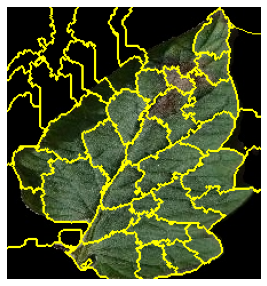

In [17]:
### GENERATE SUPERPIXEL
fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))
ax1.bbox_inches='tight'
ax1.pad_inches = 0
ax1.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.imshow(mark_boundaries(tempRF, explanationRF.segments))

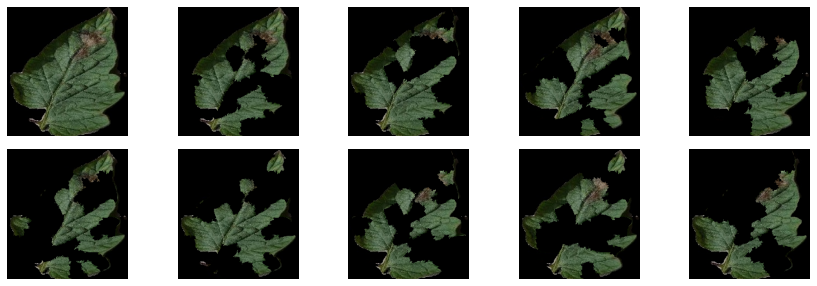

In [18]:
from matplotlib import gridspec
## VISUALIZE SOME PERTURBATIONS
# create a figure
fig = plt.figure()
# to change size of subplot's
fig.set_figheight(5)
# set width of each subplot as 8
fig.set_figwidth(15)

# create grid for different subplots
spec = gridspec.GridSpec(ncols=5, nrows=2, wspace=0.1, hspace=0.1)

i=0
for perturbationImg in RFPerturbationImgs:
    p = fig.add_subplot(spec[i])
    p.axis('off')
    p.imshow(perturbationImg)
    i = i + 1
    if i > 9:
      break

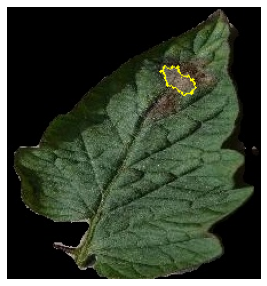

In [19]:
######################
## SHOW EXPLANATION ##
######################
fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))
ax1.bbox_inches='tight'
ax1.pad_inches = 0
ax1.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.imshow(mark_boundaries(tempRF, maskRF))

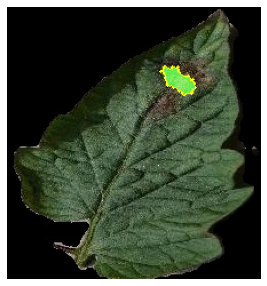

In [20]:
###############################
## SHOW POSITIVE EXPLANATION ##
###############################
tempRFP, maskRFP = explanationRF.get_image_and_mask(explanationRF.top_labels[0], positive_only=False, num_features=1, hide_rest=False)
fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))
ax1.bbox_inches='tight'
ax1.pad_inches = 0
ax1.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.imshow(mark_boundaries(tempRFP, maskRFP))

Explanations with CNN

In [57]:
def get_CNN_image(path):
  image = cv2.imread(path)
  image = cv2.resize(image, (223,223))
  return image

CNNimg = get_CNN_image(image2explain)
CNNimg = cv2.cvtColor(CNNimg, cv2.COLOR_BGR2RGB)

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

preprocess_transform = get_preprocess_transform()

RFPerturbationImgs = []
def batch_predictDCNN(images):
    DCNNmodel.eval()
    for image in images:
      RFPerturbationImgs.append(image)
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    DCNNmodel.to(device)
    batch = batch.to(device)
    logits = DCNNmodel(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()


explainerCNN = lime_image.LimeImageExplainer()
explanationCNN = explainerCNN.explain_instance(CNNimg, 
                                         batch_predictDCNN, # classification function
                                         top_labels=2, 
                                         hide_color=0, 
                                         num_samples=4000)



In [63]:
tempCNN, maskCNN = explanationCNN.get_image_and_mask(explanationCNN.top_labels[0], positive_only=True, num_features=1, hide_rest=False)

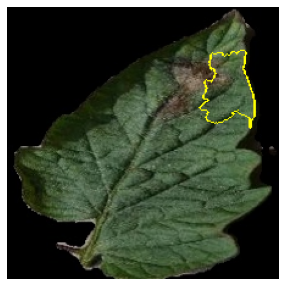

In [64]:
######################
## SHOW EXPLANATION ##
######################
fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))
ax1.bbox_inches='tight'
ax1.pad_inches = 0
ax1.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.imshow(mark_boundaries(tempCNN, maskCNN))

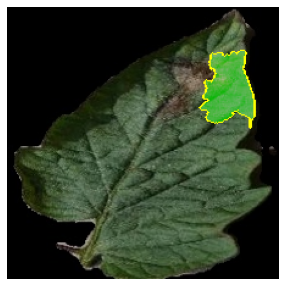

In [65]:
###############################
## SHOW POSITIVE EXPLANATION ##
###############################
tempCNNP, maskCNNP = explanationCNN.get_image_and_mask(explanationCNN.top_labels[0], positive_only=False, num_features=1, hide_rest=False)
fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))
ax1.bbox_inches='tight'
ax1.pad_inches = 0
ax1.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.imshow(mark_boundaries(tempCNNP, maskCNNP))

Explanations with Pretrained CNN

In [25]:
def get_PCNN_image(path):
  image = cv2.imread(path)
  image = cv2.resize(image, (226,226))
  return image

PCNNimg = get_PCNN_image(image2explain)
PCNNimg = cv2.cvtColor(PCNNimg, cv2.COLOR_BGR2RGB)

def batch_predictPDCNN(images):
    Pretrainedmodel.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Pretrainedmodel.to(device)
    batch = batch.to(device)
    logits = Pretrainedmodel(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()


explainerPCNN = lime_image.LimeImageExplainer()
explanationPCNN = explainerPCNN.explain_instance(PCNNimg, 
                                         batch_predictPDCNN, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=5000)

In [26]:
tempPCNN, maskPCNN = explanationPCNN.get_image_and_mask(explanationPCNN.top_labels[0], positive_only=True, num_features=1, hide_rest=False)

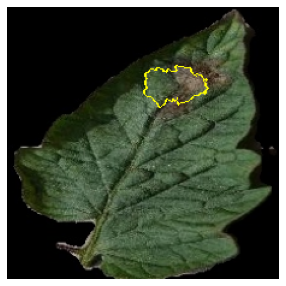

In [27]:
######################
## SHOW EXPLANATION ##
######################
fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))
ax1.bbox_inches='tight'
ax1.pad_inches = 0
ax1.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.imshow(mark_boundaries(tempPCNN, maskPCNN))

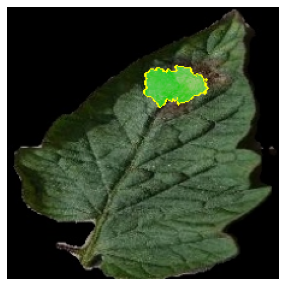

In [28]:
###############################
## SHOW POSITIVE EXPLANATION ##
###############################
tempCNNP, maskCNNP = explanationPCNN.get_image_and_mask(explanationPCNN.top_labels[0], positive_only=False, num_features=1, hide_rest=False)
fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))
ax1.bbox_inches='tight'
ax1.pad_inches = 0
ax1.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.imshow(mark_boundaries(tempCNNP, maskCNNP))

# 5. Generating Explanations with LIME Using Compact-Watershed

In [29]:
image2explain = '/content/dataset/tomato-dataset/test/Tomato___Late_blight/image (1076)_cropped_1.JPG'

Explanations with Random Forest

In [30]:
## LIME 
from skimage.segmentation import watershed, quickshift, slic
from skimage.color import rgb2gray
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.filters import sobel

def RFcustomSegmentationFunction(image):
  gradient = sobel(rgb2gray(image))
  segments = watershed(gradient, markers=250, compactness=0.001)
  return segments

explainerRF = lime_image.LimeImageExplainer()
explanationRF = explainerRF.explain_instance(RFimg, 
                                         batch_predict,
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=5000, segmentation_fn=RFcustomSegmentationFunction)


In [31]:
tempRF, maskRF = explanationRF.get_image_and_mask(explanationRF.top_labels[0], positive_only=True, num_features=1, hide_rest=False)

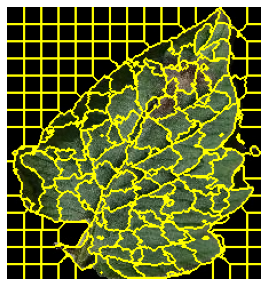

In [32]:
### GENERATE SUPERPIXEL
fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))
ax1.bbox_inches='tight'
ax1.pad_inches = 0
ax1.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.imshow(mark_boundaries(tempRF, explanationRF.segments))

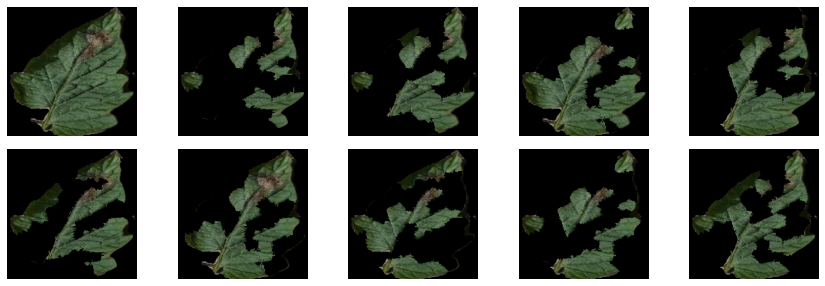

In [33]:
from matplotlib import gridspec
## VISUALIZE SOME PERTURBATIONS
# create a figure
fig = plt.figure()
# to change size of subplot's
fig.set_figheight(5)
# set width of each subplot as 8
fig.set_figwidth(15)

# create grid for different subplots
spec = gridspec.GridSpec(ncols=5, nrows=2, wspace=0.1, hspace=0.1)

i=0
for perturbationImg in RFPerturbationImgs:
    p = fig.add_subplot(spec[i])
    p.axis('off')
    p.imshow(perturbationImg)
    i = i + 1
    if i > 9:
      break

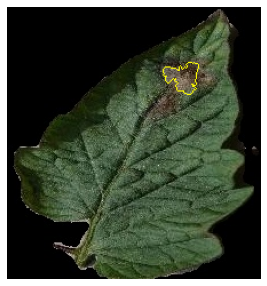

In [34]:
######################
## SHOW EXPLANATION ##
######################
fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))
ax1.bbox_inches='tight'
ax1.pad_inches = 0
ax1.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.imshow(mark_boundaries(tempRF, maskRF))

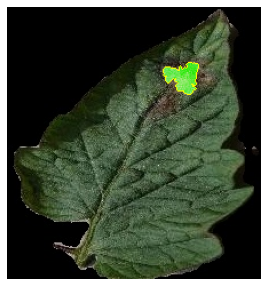

In [35]:
###############################
## SHOW POSITIVE EXPLANATION ##
###############################
tempRFP, maskRFP = explanationRF.get_image_and_mask(explanationRF.top_labels[0], positive_only=False, num_features=1, hide_rest=False)
fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))
ax1.bbox_inches='tight'
ax1.pad_inches = 0
ax1.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.imshow(mark_boundaries(tempRFP, maskRFP))

Explanations with CNN

In [69]:
def get_CNN_image(path):
  image = cv2.imread(path)
  image = cv2.resize(image, (224,224))
  return image

CNNimg = get_CNN_image(image2explain)
CNNimg = cv2.cvtColor(CNNimg, cv2.COLOR_BGR2RGB)

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

preprocess_transform = get_preprocess_transform()

RFPerturbationImgs = []
def batch_predictDCNN(images):
    DCNNmodel.eval()
    for image in images:
      RFPerturbationImgs.append(image)
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    DCNNmodel.to(device)
    batch = batch.to(device)
    logits = DCNNmodel(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

def CNNcustomSegmentationFunction(image):
  gradient = sobel(rgb2gray(image))
  segments = watershed(gradient, markers=76, compactness=0.001)
  return segments


explainerCNN = lime_image.LimeImageExplainer()
explanationCNN = explainerCNN.explain_instance(CNNimg, 
                                         batch_predictDCNN, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=5000, segmentation_fn=CNNcustomSegmentationFunction)



In [72]:
tempCNN, maskCNN = explanationCNN.get_image_and_mask(explanationCNN.top_labels[0], positive_only=True, num_features=1, hide_rest=False)

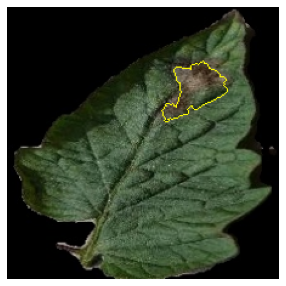

In [73]:
######################
## SHOW EXPLANATION ##
######################
fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))
ax1.bbox_inches='tight'
ax1.pad_inches = 0
ax1.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.imshow(mark_boundaries(tempCNN, maskCNN))

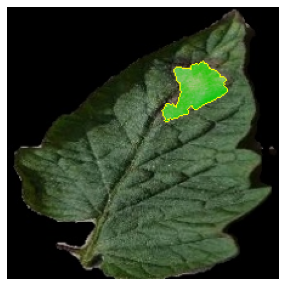

In [74]:
###############################
## SHOW POSITIVE EXPLANATION ##
###############################
tempCNNP, maskCNNP = explanationCNN.get_image_and_mask(explanationCNN.top_labels[0], positive_only=False, num_features=1, hide_rest=False)
fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))
ax1.bbox_inches='tight'
ax1.pad_inches = 0
ax1.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.imshow(mark_boundaries(tempCNNP, maskCNNP))

Explanations with Pretrained CNN

In [40]:
def get_PCNN_image(path):
  image = cv2.imread(path)
  image = cv2.resize(image, (226,226))
  return image

PCNNimg = get_PCNN_image(image2explain)
PCNNimg = cv2.cvtColor(PCNNimg, cv2.COLOR_BGR2RGB)

def batch_predictPDCNN(images):
    Pretrainedmodel.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Pretrainedmodel.to(device)
    batch = batch.to(device)
    logits = Pretrainedmodel(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

def PCNNcustomSegmentationFunction(image):
  gradient = sobel(rgb2gray(image))
  segments = watershed(gradient, markers=80, compactness=0.001)
  return segments


explainerPCNN = lime_image.LimeImageExplainer()
explanationPCNN = explainerPCNN.explain_instance(PCNNimg, 
                                         batch_predictPDCNN, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=5000, segmentation_fn=PCNNcustomSegmentationFunction)

In [41]:
tempPCNN, maskPCNN = explanationPCNN.get_image_and_mask(explanationPCNN.top_labels[0], positive_only=True, num_features=2, hide_rest=False)

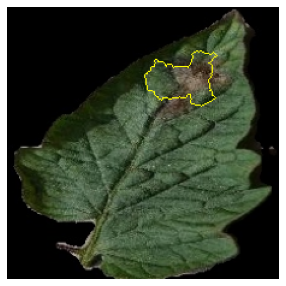

In [42]:
######################
## SHOW EXPLANATION ##
######################
fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))
ax1.bbox_inches='tight'
ax1.pad_inches = 0
ax1.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.imshow(mark_boundaries(tempPCNN, maskPCNN))

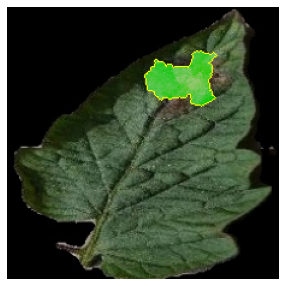

In [43]:
###############################
## SHOW POSITIVE EXPLANATION ##
###############################
tempCNNP, maskCNNP = explanationPCNN.get_image_and_mask(explanationPCNN.top_labels[0], positive_only=False, num_features=2, hide_rest=False)
fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))
ax1.bbox_inches='tight'
ax1.pad_inches = 0
ax1.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.imshow(mark_boundaries(tempCNNP, maskCNNP))